# Stochastic Oscillator Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### Stochastic Oscillator approach
* In N days, this indicator catches whether overBuy/Sell happens or not by comparing trend and current price's relative position.  
* Fast %K = ((current price - high price) / (high price - low price)) * 100
* Fast %D = Moving average of Fast %K
* Slow %K = Fast %D itself
* Slow %D = Moving average of Slow %K

[Strategy]<br>
1) By (20, 80) or (30, 70) if %K's position is under/upper of that value, buy/sell.<br>
2) If K<=20 and K start golden-cross over D then buy, else K>=80 and K start dead-cross over D then sell.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [23]:
def RSI(pr_df, ndays=14):
    pr = pr_df.copy()
    code = pr.columns[0]
    delta = pr['close'].diff(1)
    delta.fillna(0,inplace=True)
    
    Up = delta.copy()
    Down = delta.copy()
    Up[Up<0] = 0
    Down[Down>0] = 0
    pr['Up'] = Up
    pr['Down'] = Down
    avgGain = SMA(pr[['Up']], ndays)['Up']
    avgLoss = abs(SMA(pr[['Down']], ndays))['Down']
    RS = avgGain / avgLoss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    pr['RSI'] = RSI
    #pr.fillna(0,inplace=True)
    return pr

In [7]:
def StochasticMaker(pr_df, n=14, m=5, t=5):
    pr = pr_df.copy()
    pr = pr.rename(columns={'adjprice':'close'})
    ndays_high = pr['high'].rolling(window=n, min_periods=1).max()
    ndays_low = pr['low'].rolling(window=n, min_periods=1).min()
    fast_k = ((pr['close'] - ndays_low) / (ndays_high - ndays_low)) * 100
    slow_k = fast_k.ewm(span=m).mean()
    slow_d = slow_k.ewm(span=t).mean()
    pr = pr.assign(fast_k=fast_k, fast_d=slow_k, slow_k=slow_k, slow_d=slow_d)
    return pr

In [27]:
def SO_Signal_v1(dff, buyK=20, sellK=80, buyRSI=30, sellRSI=70, velocity='fast'):
    df = dff.copy()
    if velocity =='fast':
        df = df[['close','fast_k','RSI']]
        df = df.rename(columns={'fast_k':'k'})
    elif velocity =='slow':
        df = df[['close','slow_k','RSI']]
        df = df.rename(columns={'slow_k':'k'})
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['k'][i]<=buyK and df['RSI'][i] <= buyRSI and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['k'][i]>=sellK  and df['RSI'][i] >= sellRSI and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [125]:
def SO_Signal_v2(dff, buyK=20, sellK=80, buyRSI=30, sellRSI=70, velocity='fast'):
    df = dff.copy()
    if velocity =='fast':
        df = df[['close','fast_k','fast_d','RSI']]
        df = df.rename(columns={'fast_k':'k','fast_d':'d'})
    elif velocity =='slow':
        df = df[['close','slow_k','slow_d','RSI']]
        df = df.rename(columns={'slow_k':'k','slow_d':'d'})
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['k'][i] > df['d'][i] and df['k'][i]<=buyK and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['k'][i] < df['d'][i] and df['k'][i]>=sellK and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [11]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [62]:
def SO_Run_v1(start, end, code,  n=14, m=5, t=5, ndays=14, buyK=20, sellK=80, buyRSI=30, sellRSI=70, velocity='fast', doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.sort_values(by=['DATE'])
    pr.index = pr['DATE'].to_list()
    pr = pr.drop(['DATE','OPEN','CODE'],axis=1)
    so = RSI(StochasticMaker(pr,n=n,m=m,t=t),ndays=ndays)
    #return so
    if doplot :
        plt.style.use('fivethirtyeight')
        #plt.figure(figsize=(12,6))
        if velocity=='fast':
            so[['RSI','fast_k','fast_d']].plot(figsize=(12,6))
        elif velocity=='slow':
            so[['RSI','slow_k','slow_d']].plot(figsize=(12,6))
        plt.title("Sthochastic Oscillator with RSI for {}".format(code))
    so_sig = SO_Signal_v1(so, buyK=buyK, sellK=sellK, buyRSI=buyRSI, sellRSI=sellRSI,velocity=velocity)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(so_sig.index, so_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(so_sig.index, so_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(so_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('Sthochastic Oscillator on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(so_sig)
    rst.index = [code]
    return rst

In [92]:
def SO_Run_v2(start, end, code,  n=14, m=5, t=5, ndays=14, buyK=20, sellK=80, buyRSI=30, sellRSI=70, velocity='fast', doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.sort_values(by=['DATE'])
    pr.index = pr['DATE'].to_list()
    pr = pr.drop(['DATE','OPEN','CODE'],axis=1)
    so = RSI(StochasticMaker(pr,n=n,m=m,t=t),ndays=ndays)
    #return so
    if doplot :
        plt.style.use('fivethirtyeight')
        #plt.figure(figsize=(12,6))
        if velocity=='fast':
            so[['RSI','fast_k','fast_d']].plot(figsize=(12,6))
        elif velocity=='slow':
            so[['RSI','slow_k','slow_d']].plot(figsize=(12,6))
        plt.title("Sthochastic Oscillator with RSI for {}".format(code))
    so_sig = SO_Signal_v2(so, buyK=buyK, sellK=sellK, buyRSI=buyRSI, sellRSI=sellRSI,velocity=velocity)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(so_sig.index, so_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(so_sig.index, so_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(so_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('Sthochastic Oscillator on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(so_sig)
    rst.index = [code]
    return rst

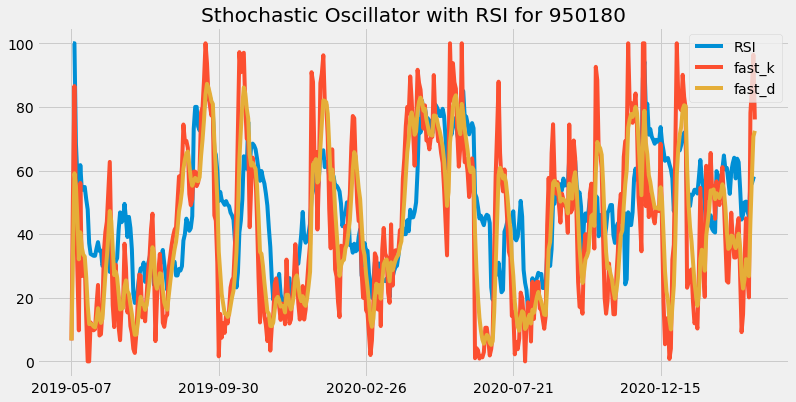

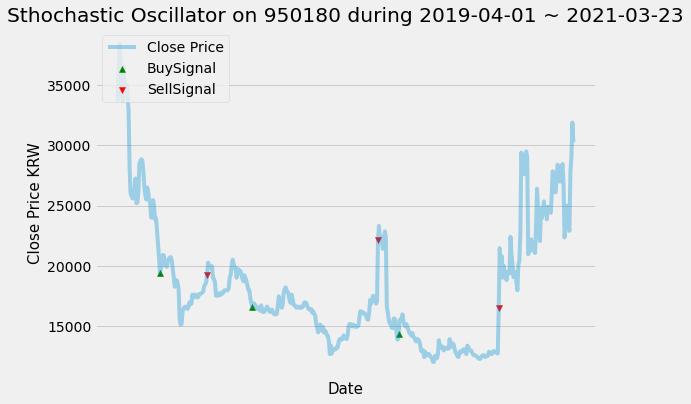

Wall time: 2.01 s


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
950180,1.53,0.67,0.34,-0.01,0.69,1.16,1.15,3,1.42


In [39]:
%%time
SO_Run_v1('2019-04-01','2021-03-23','950180',14,5,3,20,20,80,20,80,'fast',True)

In [89]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570','950180']:
    total = pd.concat([total,SO_Run_v1(start,end,cd,15,5,3,9,20,80,20,80,'fast',False)])

Wall time: 7.98 s


In [90]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.16,0.5,0.09,-0.03,0.32,1.04,1.04,4,0.63
005935,1.44,0.83,0.14,-0.11,0.33,1.07,1.06,6,1.23
034220,0.92,0.67,0.22,-0.28,0.6,1,0.99,6,-0.21
066570,1.03,0.67,0.19,-0.15,0.23,1.01,1,6,-0.14
950180,0.52,0.2,0.07,-0.28,0.69,0.89,0.88,5,-2.17


In [87]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570','950180']:
    total = pd.concat([total,SO_Run_v1(start,end,cd,15,5,3,9,20,80,20,80,'slow',False)])

Wall time: 8.1 s


In [88]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.28,1,0.12,0.01,0.32,1.07,1.06,4,1.82
005935,1.17,0.75,0.09,-0.08,0.33,1.04,1.04,4,0.55
034220,0.71,0.33,0.12,-0.27,0.6,0.91,0.89,3,-0.98
066570,1.23,0.5,0.35,-0.11,0.23,1.07,1.05,4,0.46
950180,1.43,0.5,0.94,-0.25,0.69,1.17,1.09,4,0.57


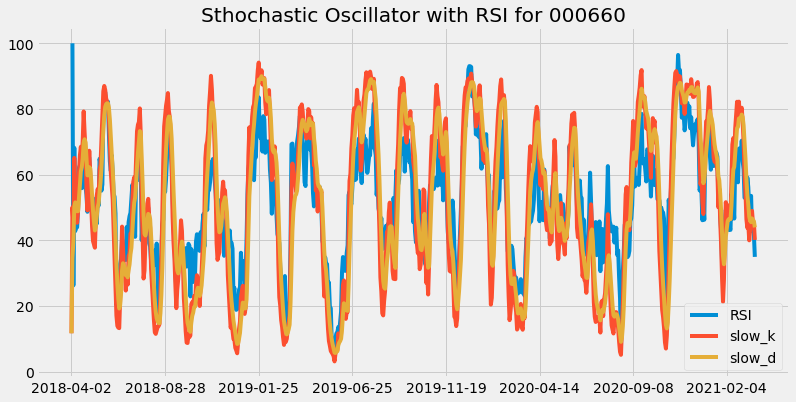

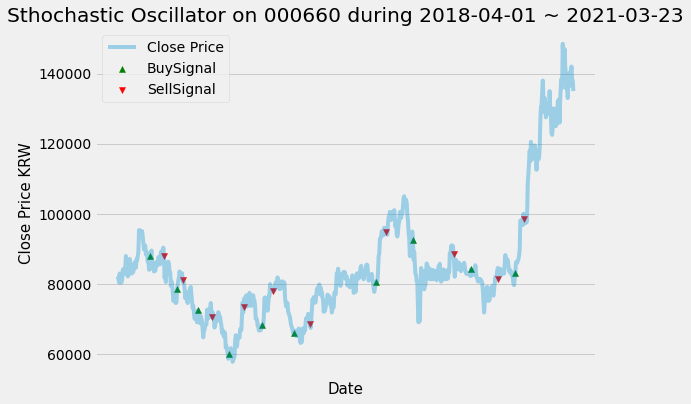

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
000660,1.88,0.7,0.22,-0.04,0.39,1.07,1.07,10,1.54


In [147]:
SO_Run_v2('2018-04-01','2021-03-23','000660',14,5,5,14,30,70,20,80,'slow',True)

In [158]:
%%time
total2 = pd.DataFrame()
start = '2018-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570','950180']:
    total2 = pd.concat([total2,SO_Run_v1(start,end,cd,14,5,5,14,30,70,20,80,'slow',False)])

Wall time: 11.4 s


In [159]:
total2

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.01,0.5,0.13,-0.11,0.32,1.01,1.01,2,-0.06
005935,1.17,0.67,0.13,-0.08,0.33,1.06,1.05,3,0.55
034220,0.76,0.5,0.1,-0.24,0.66,0.94,0.93,4,-1.00
066570,0.48,0,-0.3,-0.31,0.62,0.69,0.69,2,-45.39
950180,0.98,0.5,0.45,-0.25,0.69,1.03,1,4,0.06


In [162]:
%%time
total2 = pd.DataFrame()
start = '2018-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570','950180']:
    total2 = pd.concat([total2,SO_Run_v1(start,end,cd,5,3,3,14,30,70,20,80,'fast',False)])

Wall time: 11.3 s


In [163]:
total2

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.05,0.5,0.14,-0.08,0.32,1.03,1.02,2,0.08
005935,1.04,0.5,0.14,-0.08,0.33,1.03,1.02,2,0.06
034220,0.8,0.5,0.12,-0.23,0.66,0.96,0.95,4,-0.71
066570,0.63,0,-0.09,-0.31,0.62,0.8,0.79,2,-1.93
950180,0.7,0.33,0.11,-0.29,0.69,0.9,0.89,3,-1.00


### Conclusion

* Even though my pairs were not predicted well some tests were good at steady stocks. It means that Stochastic Oscillator works well when a given stock has steady movement. If there exists trend then it would be bad indicator. In that case, MACD indicator works well.
* And it originally generates lots of signals. Many are wrong among them. So RSI or other trend complementary indicator would be needed for buying when its current position is highly in up-ward state.